# My DUSTED (ish) Pipeline
You have to start by defining the dataset info. 
Currently it only works with librispeech (oops)
1. Loading in the Dataset

In [16]:
from pathlib import Path

name = "librispeech-dev-clean"
in_dir = Path("data/dev-clean")
align_dir = Path("data/alignments/dev-clean")
feat_dir = Path("features")
audio_ext = ".flac" 

In [17]:
from encode import sample_files
from utils.features import DataSet

dataset = DataSet(
    name, in_dir, align_dir, feat_dir, audio_ext 
)

# Choose how many files you want to sample. (-1 = all)
sample_size = 100
sampled_paths = sample_files(dataset, sample_size)
print(len(sampled_paths))

100


In [18]:
# If you want to be fun, check the ladys:
sampled_paths = [
    Path("data/dev-clean/174/50561/174-50561-0005.flac"), 
    Path("data/dev-clean/3081/166546/3081-166546-0058.flac"), 
    Path("data/dev-clean/84/121550/84-121550-0026.flac"),
    Path("data/dev-clean/174/50561/174-50561-0008.flac")
]

In [19]:
from distance import load_units
from joblib import Parallel, delayed

# If the units are already computed and saved in the feat_dir you can simply load them in: 
results = Parallel(n_jobs=2)([
    delayed(load_units)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

Loading Units: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


In [ ]:
from encode import get_units
from joblib import Parallel, delayed

# Otherwise you have to first encode the waveforms to get the units.
# Encoding is done using Benji's hubert and kmeans models.
results = Parallel(n_jobs=2)([
    delayed(get_units)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting units: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


The next is a little sanity check for the number of word types and their occurences in our sampled data. 
The true words are also stored in an array for later understanding and visualisation.

In [20]:
from collections import Counter
import pandas as pd
import ace_tools_open as tools

num_words = len(hubert_words)
true_words = []

for w in range(num_words): 

    if not isinstance(hubert_words[w].true_word, str):
        true_words.append("_")
    else:
        true_words.append(hubert_words[w].true_word)
        

counts = Counter(true_words)

word_counts_df = pd.DataFrame(counts.items(), columns=["Word", "Count"])
word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)
tools.display_dataframe_to_user(name="Sorted Word Counts", dataframe=word_counts_df)

Sorted Word Counts


2. Calculating the distances between words

In [21]:
from distance import calculate_distance

# Need to specify where the dist matrices are stored -> could maybe look at a different naming convention
out_dir_dusted = Path(f"output/dusted/{sample_size}")
out_dir_hubert = Path(f"output/hubert/{sample_size}")

# If calculate_distance is called with only the words, it does not save the matrices
dist_mat_dusted = calculate_distance(dusted_words, out_dir_dusted)
print()
dist_mat_hubert = calculate_distance(hubert_words, out_dir_hubert)

Calculating Distances: 100%|██████████| 103/103 [00:00<00:00, 9526.62it/s]


[[0.         1.         1.         1.         1.        ]
 [1.         0.         1.         1.         1.        ]
 [1.         1.         0.         1.         0.83333333]
 [1.         1.         1.         0.         0.83333333]
 [1.         1.         0.83333333 0.83333333 0.        ]]



Calculating Distances:   0%|          | 0/103 [00:00<?, ?it/s]

Calculating Distances: 100%|██████████| 103/103 [00:00<00:00, 5939.72it/s]

[[0.    1.    1.    1.    1.   ]
 [1.    0.    1.    1.    1.   ]
 [1.    1.    0.    1.    0.875]
 [1.    1.    1.    0.    0.875]
 [1.    1.    0.875 0.875 0.   ]]


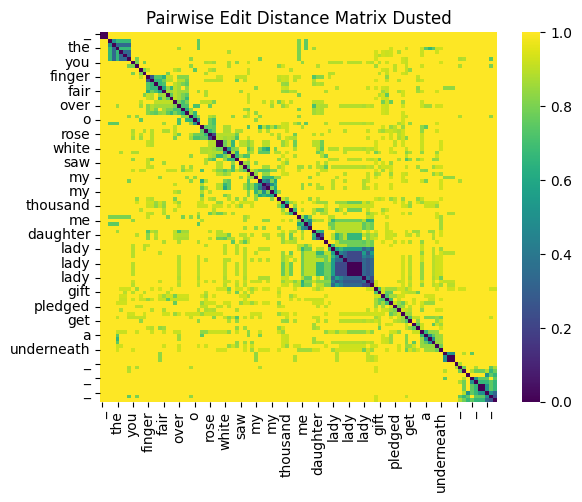

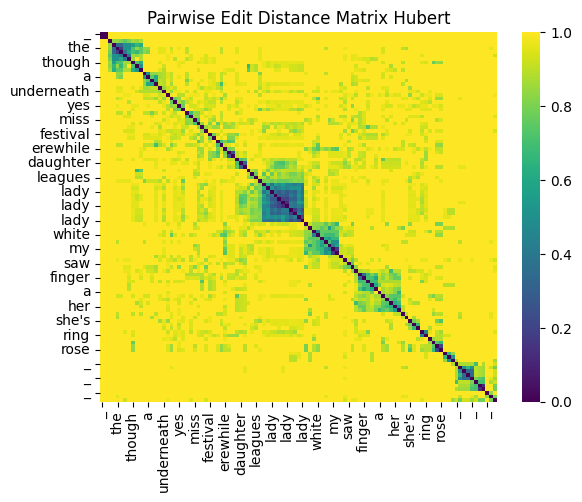

In [22]:
from eval import pairwise_edit_dist_mat

# Visualise the distances
pairwise_edit_dist_mat(dist_mat_dusted, "Pairwise Edit Distance Matrix Dusted", true_words)
pairwise_edit_dist_mat(dist_mat_hubert, "Pairwise Edit Distance Matrix Hubert", true_words)

In [26]:
from cluster import cluster
from eval import get_word_clusters

# Get the int_clusters for each of the matrices
dust_clusters = cluster(dist_mat_dusted, 0.4)
hub_clusters = cluster(dist_mat_hubert, 0.4)

# Convert these to word clusters
dust_word_clusters = get_word_clusters(dust_clusters, dusted_words)
hub_word_clusters = get_word_clusters(hub_clusters, hubert_words)

In [29]:
from eval import ned

# Compute the ned for my dusted and hubert clusters - atm my NED is computed only using clusters with > 1 words
print("DUSTED:")
ned_dusted = ned(dust_word_clusters)
print(f"{"-"*100}\nHuBERT:")
ned_hubert = ned(hub_word_clusters)

print(f"DUSTED NED: {ned_dusted}")
print(f"HuBERT NED: {ned_hubert}")

DUSTED:
Cluster 68: 4
87 90 ('daughter', 'water')

----------------------------------------------------------------------------------------------------
HuBERT:
Cluster 71: 4
87 90 ('daughter', 'water')

DUSTED NED: 0.05263157894736842
HuBERT NED: 0.058823529411764705


In [30]:
from eval import words_from_word_units, clusters_purity
            
dust_just_words_clusters = words_from_word_units(dust_word_clusters)
inpurity, total = clusters_purity(dust_just_words_clusters)
print(f"{total} Clusters with inpurity: {round(inpurity*100, 3)}%")
print(f"        And {inpurity*total} Duplicate clusters")

79 Clusters with inpurity: 30.38%
        And 24.0 Duplicate clusters
